# Overfitting & Cross-Validation

{ref}`👨‍🏫 [Sync] <delivery_modes>`

In [1]:
%matplotlib inline

import pandas
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import exp, log1p, sqrt

base = pandas.read_csv("../data/paris_abb.csv.zip")
res = pandas.read_parquet("../data/lm_results.parquet")
db = base.join(res)

## Overfitting

So we have models but, are they any good? 

Model evaluation the ML is all about predictive performance (remember the $\hat{\beta}$ Vs $\hat{y}$, this is all about $\hat{y}$).

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/p

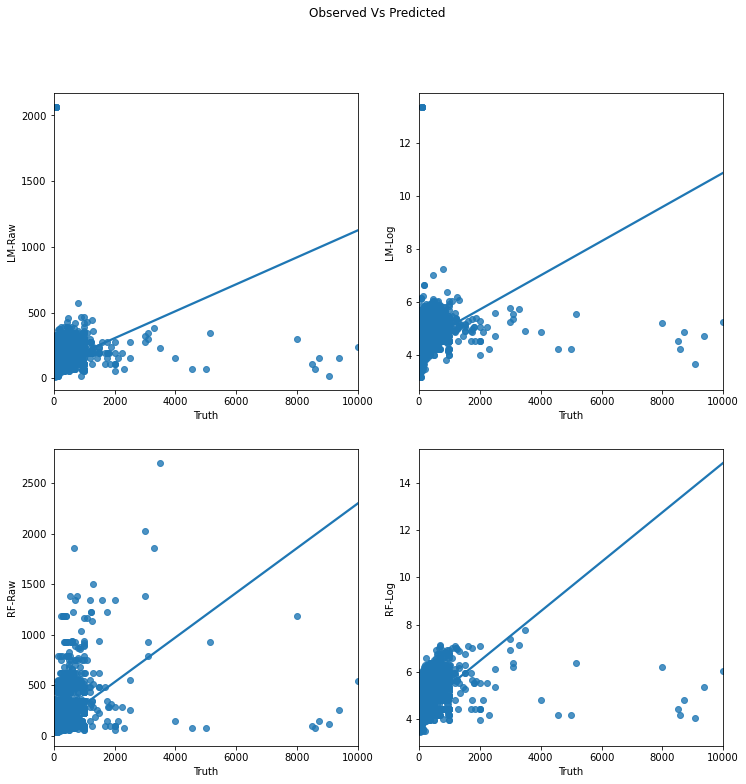

In [2]:
f, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()
for i, m in enumerate(res.columns.drop("Truth")):
    ax = axs[i]
    sns.regplot("Truth", 
                m, 
                res,
                ci=None,
                ax=ax
               )
f.suptitle(f"Observed Vs Predicted")
plt.show()

There are several measures, we'll use two:

- $R^2$

In [3]:
from sklearn.metrics import r2_score

Let's compare apparent performance:

In [4]:
r2s = pandas.Series({"LM-Raw": r2_score(db["Truth"], 
                                        db["LM-Raw"]
                                       ),
                     "LM-Log": r2_score(log1p(db["Truth"]),
                                        db["LM-Log"]
                                       ),
                     "RF-Raw": r2_score(db["Truth"],
                                        db["RF-Raw"]
                                       ),
                     "RF-Log": r2_score(log1p(db["Truth"]),
                                        db["RF-Log"]
                                       ),
                    })
r2s

LM-Raw    0.102694
LM-Log    0.315159
RF-Raw    0.225217
RF-Log    0.443318
dtype: float64

- (R)MSE

In [5]:
from sklearn.metrics import mean_squared_error as mse

And a similar comparison (where we can convert all predictions to price units):

In [6]:
mses = pandas.Series({"LM-Raw": mse(db["Truth"], 
                                    db["LM-Raw"]
                                   ),
                      "LM-Log": mse(db["Truth"],
                                    exp(db["LM-Log"])
                                   ),
                      "RF-Raw": mse(db["Truth"],
                                    db["RF-Raw"]
                                   ),
                      "RF-Log": mse(db["Truth"],
                                    exp(db["RF-Log"])
                                   ),
                     }).apply(sqrt)
mses

LM-Raw     149.522153
LM-Log    7570.085725
RF-Raw     138.939346
RF-Log     140.904608
dtype: float64

Now this is great news for the random forest! 🎉

... or is it?

Let's do a thought experiment. Imagine that AirBnb, for some reason, did not initially move into the Passy neighbourhood. 

Let's quickly retrain our models for that world. For convenience, let's focus on the raw models, not those based on logs:

In [7]:
room_type_ds = pandas.get_dummies(db["room_type"])
X = pandas.concat([db[["bathrooms", "bedrooms"]],
                   room_type_ds.drop("Entire home/apt",
                                     axis=1)
                  ], axis=1
                 )
# Passy IDs
pi = db.query("neighbourhood_cleansed == 'Passy'").index
# Non Passy IDs
npi = db.index.difference(pi)

# Non Passy data (same as in previous notebook)
X_np = X.reindex(npi)

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Linear model
lm_raw_np_model = LinearRegression().fit(X_np, 
                                         db.loc[npi, "Price"]
                                        )
lm_raw_np = lm_raw_np_model.predict(X_np)
# RF
rf_raw_np_model = RandomForestRegressor(n_estimators=100,
                                        max_features=None
                                       )\
                                      .fit(X_np, 
                                           db.loc[npi, "Price"]
                                          )
rf_raw_np = rf_raw_np_model.predict(X_np)

The _apparent_ performance of our model is similar, a bit better if anything:

In [9]:
mses_np = pandas.Series({"LM-Raw": mse(db.loc[npi, "Truth"], 
                                       lm_raw_np
                                      ),
                         "RF-Raw": mse(db.loc[npi, "Truth"],
                                       rf_raw_np
                                      ),
                        }).apply(sqrt)
mses_np

LM-Raw    144.326619
RF-Raw    134.277649
dtype: float64

In [10]:
mses.reindex(mses_np.index)

LM-Raw    149.522153
RF-Raw    138.939346
dtype: float64

Now imagine that Passy comes on the AirBnb market and we need to provide price estimates for its properties. We can use our model to make predictions:

In [11]:
# Linear predictions
lm_raw_passy_pred = lm_raw_np_model.predict(X.reindex(pi))
lm_raw_passy_pred = pandas.Series(lm_raw_passy_pred,
                                  index=pi
                                 )
# RF predictions
rf_raw_passy_pred = rf_raw_np_model.predict(X.reindex(pi))
fr_raw_passy_pred = pandas.Series(rf_raw_passy_pred,
                                  index=pi
                                 )

How's our model doing now?

In [12]:
mses_p = pandas.Series({"LM-Raw": mse(db.loc[pi, "Truth"], 
                                      lm_raw_passy_pred
                                     ),
                        "RF-Raw": mse(db.loc[pi, "Truth"],
                                      fr_raw_passy_pred
                                     ),
                       }).apply(sqrt)
mses_p

LM-Raw    235.291495
RF-Raw    218.293239
dtype: float64

In [13]:
mses_np

LM-Raw    144.326619
RF-Raw    134.277649
dtype: float64

Not that great on data the models have not seen before.

Linear regression is a particular case in that, given the features chosen, one cannot tweak much more; but the RF does allow us to tweak things slightly differently. How is a matter of (computational) brute force and a bit of savvy-ness in designing the data split.

## Cross-Validation to the rescue

- What it does: give you a better sense of the actual performance of your model
- What it doesn't (estimate a better model per-se)

### Train/test split

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    db["Price"],
                                                    test_size=0.8
                                                   )

For the linear model:

In [16]:
lm_estimator = LinearRegression()
# Fit on X/Y train
lm_estimator.fit(x_train, y_train)
# Predict on X test
lm_y_pred = lm_estimator.predict(x_test)
# Evaluate on Y test
sqrt(mse(y_test, lm_y_pred))

146.63691841889124


For the random forest:

In [17]:
rf_estimator = RandomForestRegressor(n_estimators=100,
                                     max_features=None
                                    )
# Train on X/Y train
rf_estimator.fit(x_train, y_train)
# Predict on X test
rf_y_pred = rf_estimator.predict(x_test)
# Evaluate on Y test
sqrt(mse(y_test, rf_y_pred))

140.59053185334008

Worse than in-testing, but better than on an entirely new set of data with (potentially) different structure.

Now, the splitting that `train_test_split` does is random. What if it happens to be very particular? Can we trust the performance scores we recover?

### $k$-fold CV

In [18]:
from sklearn.model_selection import cross_val_score

For the linear model:

In [19]:
lm_kcv_mses = cross_val_score(LinearRegression(),
                              X,
                              db["Price"],
                              cv=5,
                              scoring="neg_mean_squared_error"
                             )
# sklearn uses neg to optimisation is alway maximisation
sqrt(-lm_kcv_mses).mean()

156.0444939069434

And for the random forest:

In [20]:
rf_estimator = RandomForestRegressor(n_estimators=100,
                                     max_features=None
                                    )
rf_kcv_mses = cross_val_score(rf_estimator,
                              X,
                              db["Price"],
                              cv=5,
                              scoring="neg_mean_squared_error"
                             )
# sklearn uses neg to optimisation is alway maximisation
sqrt(-rf_kcv_mses).mean()

141.65779397663923

These would be more reliable measures of model performance. The difference between CV'ed estimates and original ones can be seen as an indication of overfitting.

In [21]:
mses

LM-Raw     149.522153
LM-Log    7570.085725
RF-Raw     138.939346
RF-Log     140.904608
dtype: float64

In our case, since we're using very few features, both models  probably already feature enough "regularisation" and the changes are not very dramatic. In other contexts, this can be a drastic change (e.g. [Arribas-Bel, Patino & Duque; 2017](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0176684)).

### Parameter optimisation in `scikit-learn`

Random Forests really can be optimised over two key parameters, `n_estimators` and `max_features`, although there are more to tweak around:

In [22]:
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Here we'll exhaustively test each combination for several values of the parameters:

In [23]:
param_grid = {
    "n_estimators": [5, 25, 50, 75, 100, 150],
    "max_features": [1, 2, 3, 4, 5]
}

We will use `GridSearchCV` to automatically work over every combination, create cross-validated scores (MSE), and pick the preferred one.

In [24]:
from sklearn.model_selection import GridSearchCV

This can get fairly computationally intensive, and it is also "embarrasingly parallel", so it's a good candidate to parallelise.

In [25]:
grid = GridSearchCV(RandomForestRegressor(),
                    param_grid,
                    scoring="neg_mean_squared_error",
                    cv=5,
                    n_jobs=-1
                   )

Once defined, we `fit` to actually execute computations on a given set of data:

In [26]:
%%time
grid.fit(X, db["Price"])

CPU times: user 631 ms, sys: 165 ms, total: 796 ms
Wall time: 10.5 s


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': [1, 2, 3, 4, 5],
                         'n_estimators': [5, 25, 50, 75, 100, 150]},
             scoring='neg_mean_squared_error')

And we can explore the output from the same `grid` object:

In [27]:
grid_res = pandas.DataFrame(grid.cv_results_)
grid_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.059308,0.002531,0.007023,0.000338,1,5,"{'max_features': 1, 'n_estimators': 5}",-14164.970336,-24324.348853,-10955.871710,-28297.397306,-27114.016072,-20971.320855,7060.913913,29
1,0.260195,0.003964,0.019304,0.000458,1,25,"{'max_features': 1, 'n_estimators': 25}",-14129.505213,-24516.056914,-10649.406165,-27980.354563,-27066.294890,-20868.323549,7101.263798,20
2,0.519160,0.003526,0.035556,0.000450,1,50,"{'max_features': 1, 'n_estimators': 50}",-14048.048029,-24529.450849,-10680.936105,-27865.459466,-27057.329039,-20836.244698,7084.651423,13
3,0.818000,0.017073,0.054218,0.002030,1,75,"{'max_features': 1, 'n_estimators': 75}",-14005.614738,-24534.834379,-10295.045845,-28000.288810,-27077.156117,-20782.587978,7234.805494,7
4,1.071697,0.034987,0.065108,0.001701,1,100,"{'max_features': 1, 'n_estimators': 100}",-14062.448420,-24476.717132,-11118.962404,-27920.867261,-27071.548980,-20930.108839,6965.483109,28


And the winner is...

In [28]:
grid_res[grid_res["mean_test_score"] \
         == \
         grid_res["mean_test_score"].max()
        ]["params"]

6    {'max_features': 2, 'n_estimators': 5}
Name: params, dtype: object

Or, we can visualise the surface generated in the grid:

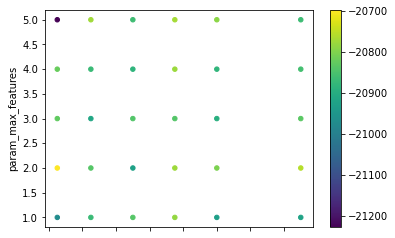

In [29]:
grid_res[["param_n_estimators", "param_max_features"]]\
        .astype(float)\
        .plot.scatter("param_n_estimators",
                      "param_max_features",
                      c=grid_res["mean_test_score"],
                      cmap="viridis"
                     );

It is also possible to see that, as expected, the more trees, the longer it takes to compute:

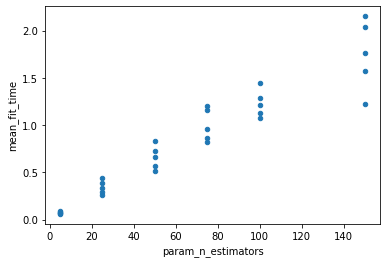

In [30]:
grid_res[["param_n_estimators", "mean_fit_time"]]\
        .astype(float)\
        .plot.scatter("param_n_estimators",
                      "mean_fit_time"
                     );

---

**EXERCISE** What's the model performance (R/MSE) of the random forest setup we've used with the optimised set of parameters from the experiment above?

---

More at:

> [https://scikit-learn.org/stable/modules/grid_search.html](https://scikit-learn.org/stable/modules/grid_search.html)